In [ ]:
"""
DB WAIT
20887507

"""
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#A helper-function to setup a proper plot
def setup_plot(title, y_label='', x_label='', newfig=True):
  if newfig:
    plt.figure()
  plt.margins(*(plt.array(plt.margins())+0.05))
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)

#A helper-function to setup a proper plot
def fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  
  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit

  setup_plot("Modulated Signal")
  plt.plot(mn, 'c')
  #plt.stem(mn, use_line_collection=True, markerfmt= 'r.', linefmt = 'r:')
  plt.show()
  
  return mn

def pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn
  
  setup_plot("Received Signal")
  plt.plot(rn, 'm')
  #plt.stem(rn, use_line_collection=True, markerfmt= 'g.', linefmt = 'g:')
  plt.show()
  
  return rn


def downsample(input, len, factor):
  output = input[:len:factor]
  return output

In [ ]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

#f1 = delta_f*10
f1 = 40
f0 = delta_f*20
print(f0, f1)

dsamp = 2
blocks = 6
L = 1024
N = L*2

print(dsamp, blocks, L, N)

882
250.0
5000.0 40
2 6 1024 2048


6144


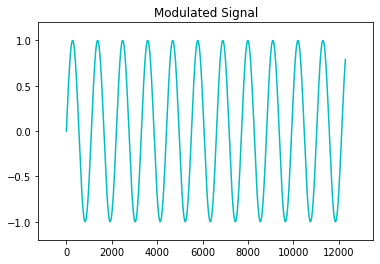

12288


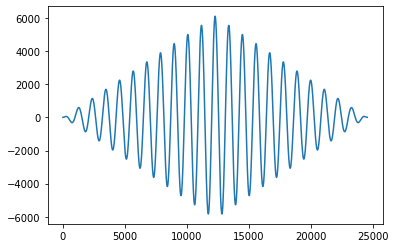

In [ ]:
bt = np.array([1])

samps1 = int(blocks*L)
print(samps1)

tt = fsk(bitseq = bt, spb = int(samps1*dsamp), f_0 = f0, f_1 = int(f1), F = fs)
print(tt.shape[0])

rt = np.correlate(tt, tt, mode = "full")
plt.plot(rt)
plt.show() 

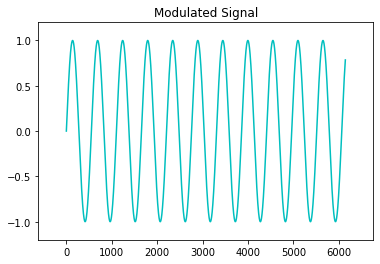

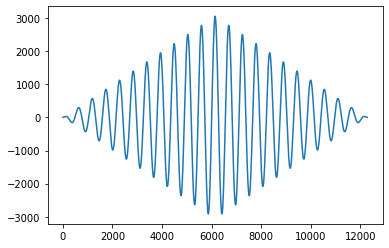

In [ ]:
tx = fsk(bitseq = bt, spb = samps1, f_0 = f0, f_1 = int(f1*dsamp), F = fs)

rtt = np.correlate(tx, tx, mode = "full")
plt.plot(rtt)
plt.show() 

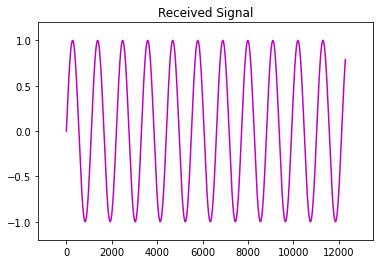

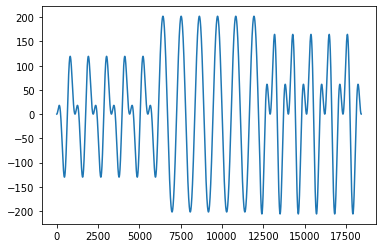

In [ ]:
rx = pollute(bitseq = bt, len_f = 0*samps1, len_b= 0*samps1, spb = samps1*dsamp, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rtr = np.correlate(rx, tx, mode = "full")
plt.plot(rtr)
plt.show() 

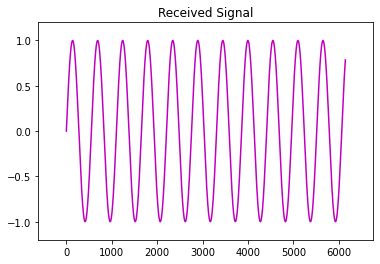

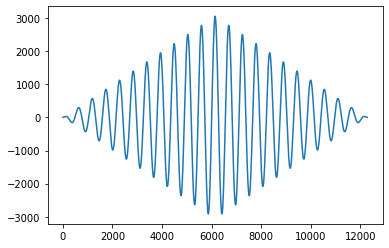

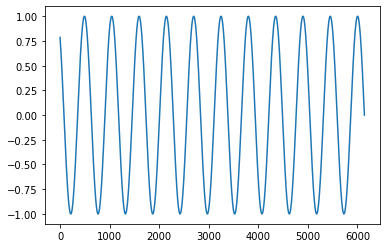

In [ ]:
"""
txd = downsample(tx, tx.shape[0], dsamp)
setup_plot("Modulated Signal")
plt.plot(txd, 'c')
plt.show()
"""

rxd = downsample(rx, rx.shape[0], dsamp)
setup_plot("Received Signal")
plt.plot(rxd, 'm')
plt.show()


rtrd = np.correlate(rxd, tx, mode = "full")
plt.plot(rtrd)
plt.show() 


mf_coef= np.flip(tx)
plt.plot(mf_coef)
plt.show()


800 200


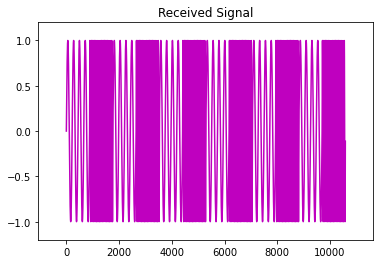

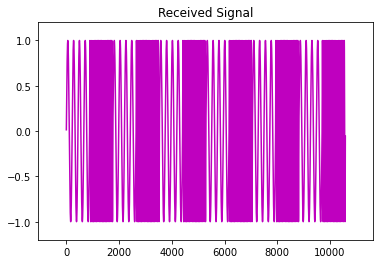

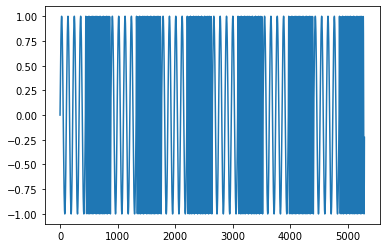

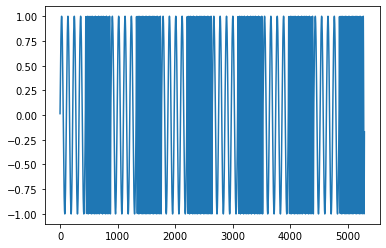

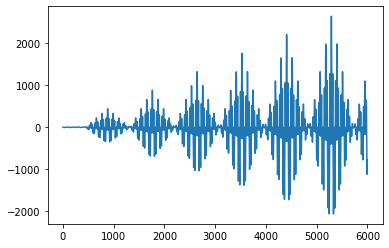

In [ ]:
f1 = 200
f0 = 800
print(f0, f1)

samps = 882


bits3 = np.array([1,0,1,0,1,0,1,0,1,0,1,0])
tx3 = pollute(bitseq = bits3, len_f = 0, len_b = 0, spb = 882, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0) #FSK encoded messsage w/ zeropadding
tx3 = downsample(tx3, 882*12,2)

rx3 = pollute(bitseq = bits3, len_f = 0, len_b = 0, spb = 882, f_0 = f0, f_1 = f1, F = fs, gain = 1, timeshift= 0.5*Ts, noise_stddev=0.0)
rx3 = downsample(rx3, 882*12,2)

plt.plot(tx3)
plt.show()

plt.plot(rx3)
plt.show()


rtr = np.correlate(rx3, tx3, mode = "full")
plt.plot(rtr[0:6000])
plt.show() 

#Downsampled Block Convolver/ Partitioned Overlap-Add

**Setting up:*
0.   Choose L = M = 1024, N = 2048 

1.   Create a single-tone message of M = 1024 samples

2.   Received signal = message + 1024 samples padding on each side

3.   Observe cross-correlation function

4.   Matched Filter (MF) coefficients = message reversed/flipped *( h[n] = 'mf_coef' )*

5.   Split MF into **B**= 6 blocks of M samples and zero-pad each block to N samples

6.   Store N-sample FFT of each MF block *( H[k] = 'mf_fft_n' )*


**Incoming Data:**
7.   For ease of use, precalculate N-sample FFT of all input blocks *( X[k] = 'xf' )* - similar to the MF

8.   Wait until **B** input blocks are available before filtering begins 

9.   Store N-sample y[n] = IFFT{ sum of X[k].H[k] }   *( y[n] = 'yn' )*

**Overlap-Add:**
10.  Progressively overlap and add all y[n]

11.  Sanity check = difference of Cross-Correlation and Overlap-Add output

882
250.0
200 800


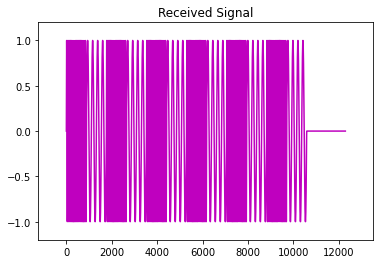

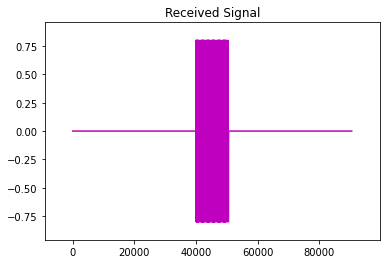

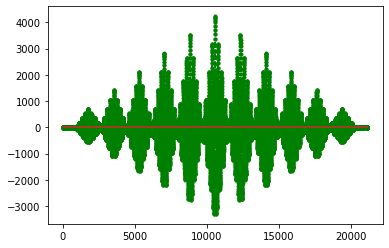

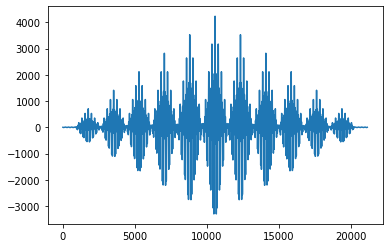

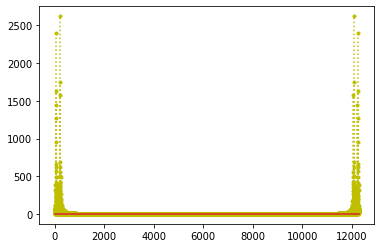

In [ ]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

f1 = 800
f0 = 200
print(f0, f1)


bits3 = np.array([1,0,1,0,1,0,1,0,1,0,1,0])
tx3_l = pollute(bitseq = bits3, len_f = 0, len_b = 852*2, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)
rx3_l = pollute(bitseq = bits3, len_f = 40000, len_b = 40000, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 0.8, timeshift= Ts, noise_stddev=0.0)


rtr = np.correlate(rx3_l[40000:50584], tx3_l[0:10584], mode = "full")
plt.stem(rtr, linefmt="g:", markerfmt = 'g.', use_line_collection= True)
plt.show() 

plt.plot(rtr)
plt.show()

mf_coef= np.flip(tx3_l)
mf_fft = np.abs(np.fft.fft(mf_coef))
plt.stem(mf_fft, linefmt="y:", markerfmt = 'y.', use_line_collection= True)
plt.show()

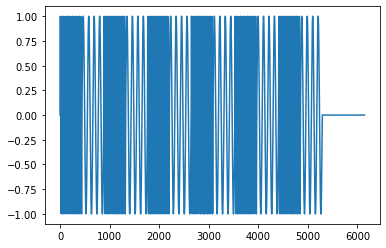

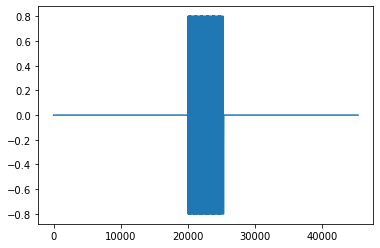

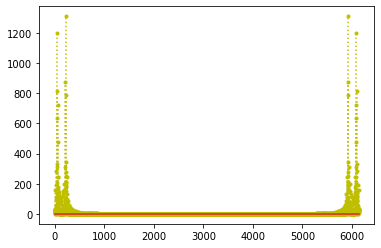

In [ ]:
L = 128*8

tx3 = downsample(tx3_l, tx3_l.shape[0], 2)
plt.plot(tx3)
plt.show()

rx3 = downsample(rx3_l, rx3_l.shape[0], 2)
plt.plot(rx3)
plt.show()

mf_coef= np.flip(tx3)
mf_fft = np.abs(np.fft.fft(mf_coef))
plt.stem(mf_fft, linefmt="y:", markerfmt = 'y.', use_line_collection= True)
plt.show()

1024
1024
2048
#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


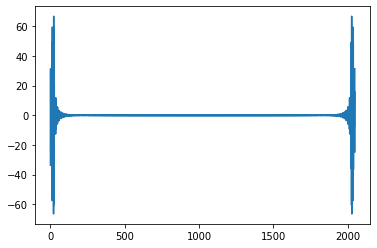

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


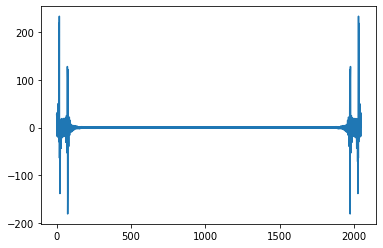

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


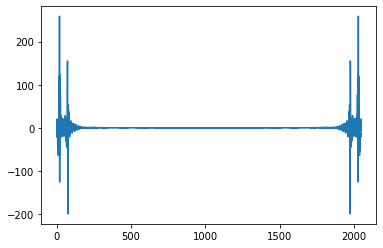

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


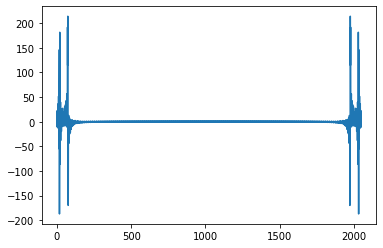

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


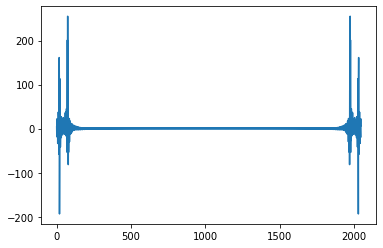

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


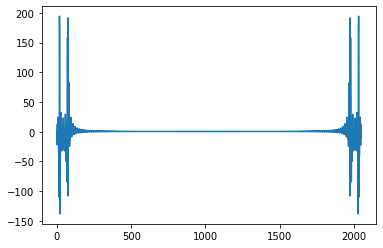

In [ ]:
M = int(mf_coef.shape[0]/6)
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.zeros(shape = (6,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (6,N), dtype= np.complex64)


cnt = 0
for j in range(0,6):
  print("#############################")
  cnt = j*M
  mf_coef_n[j] = np.append(mf_coef[cnt:cnt+M] , np.zeros(shape = (N-M,)) )
  #plt.plot(mf_coef_n[j])
  #plt.show()

  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )
  plt.plot((mf_fft_n[j]))
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


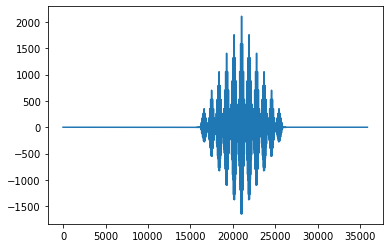

In [ ]:
xf = np.zeros(shape = (39,N), dtype= np.complex64)
yn = np.zeros(shape = (34,N), dtype= np.complex64)
ola = np.zeros(shape = (N+33*L,), )

for k in range(0, 39):
  cnt = k*L
  xf[k] = np.append( rx3[cnt:cnt+L], np.zeros(shape = (N-L,), dtype= np.complex64) )
  xf[k] = np.fft.fft(xf[k])
  #plt.plot(xf[k])
  #plt.show()

for i in range(5,39):
  for j in range(0,6):
    yn[i-5] = yn[i-5] + xf[i-j]*mf_fft_n[j]
  yn[i-5] = np.fft.ifft(yn[i-5])
  #plt.plot(yn[i-5])
  #plt.show()


ola[0:L] = yn[0][0:L]
ola[L:N] = yn[0][L:N]

for k in range(1, 34):
  ola[k*L : N+(k-1)*L] = ola[k*L : N+(k-1)*L] + yn[k][0:N-L]
  ola[N+(k-1)*L : (k+1)*L] = yn[k][N-L:L]
  ola[(k+1)*L : N+k*L] = yn[k][L:N]

plt.plot(ola)
plt.show()

#Extra Code

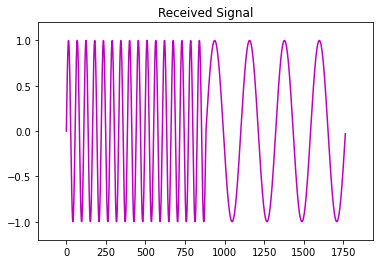

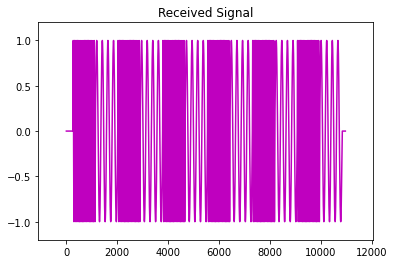

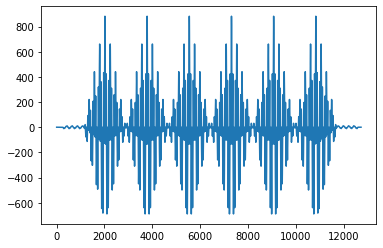

In [ ]:
bits5 = np.array([1,0])
bits5_r = np.array([1,0,1,0,1,0,1,0,1,0,1,0])

tx5 = pollute(bitseq = bits5, len_f = 0, len_b= 0, spb = samps, f_0 = 200, f_1 = 800, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rx5 = pollute(bitseq = bits5_r, len_f = 256, len_b= 128,spb = samps, f_0 = 200, f_1 = 800, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rtr = np.correlate(rx5, tx5, mode = "full")
plt.plot(rtr)
plt.show() 